# Multi-objective adjoint optimization

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

In this notebook, we will show how to use the adjoint plugin efficiently for objectives involving several simulations.

One common application of this, which we will explore, is objective functions that depend on several frequencies.

In [1]:
import numpy as np
import jax.numpy as jnp
import jax

import tidy3d as td
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run, run_async

### Setup

First, let's define the frequencies that our objective will depend on

In [2]:
freq_min = 1e14
freq_max = 2e14
num_freqs = 2
freqs = np.linspace(freq_min, freq_max, num_freqs)

wavelength_max = td.C_0 / freq_min


Now we set up some physical parameters.

We will be putting a `td.Box` in the center of a domain with a point source on one side and a diffraction monitor on the other.

The objective will involve summing the power of the 0th order diffraction order over all frequencies defined above.

The gradient of this objective will be computed with respect to the permittivity of the box.

In [3]:
permittivity_val = 2.0

lx = wavelength_max
ly = wavelength_max
lz = wavelength_max

buffer = 2 * wavelength_max

Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = lz + 2 * buffer

src_pos_x = -Lx / 2 + buffer / 2
mnt_pos_x = +Lx / 2 - buffer / 2


In [4]:
def make_sim(permittivity: float, freq: float) -> tda.JaxSimulation:
    """Make a simulation as a function of the box permittivity and the frequency."""

    box = tda.JaxStructure(
        geometry=tda.JaxBox(center=(0.0, 0.0, 0.0), size=(lx, ly, lz)),
        medium=tda.JaxMedium(permittivity=permittivity),
    )

    src = td.PointDipole(
        center=(src_pos_x, 0, 0),
        polarization="Ey",
        source_time=td.GaussianPulse(
            freq0=freq,
            fwidth=freq / 10,
        ),
    )

    mnt = td.DiffractionMonitor(
        center=(mnt_pos_x, 0, 0),
        size=(0, td.inf, td.inf),
        freqs=[freq],
        name="diffraction",
    )

    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        input_structures=[box],
        output_monitors=[mnt],
        sources=[src],
        grid_spec=td.GridSpec.auto(wavelength=td.C_0 / freq),
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(), y=td.Boundary.periodic(), z=td.Boundary.periodic()
        ),
        run_time=5000 / freq,
    )


Let's try it out and make a jax simulation to plot

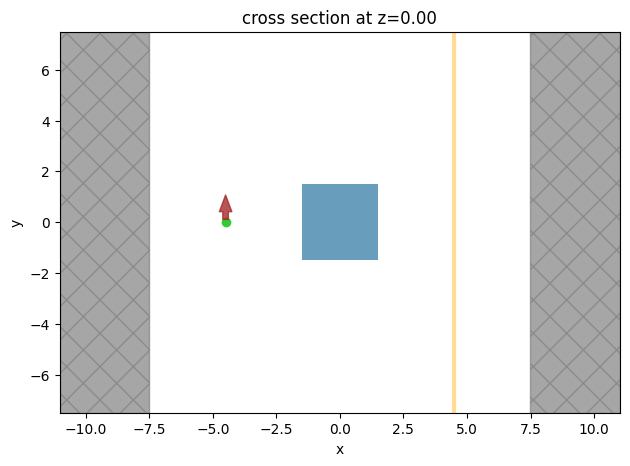

In [5]:
jax_sim = make_sim(permittivity=permittivity_val, freq=freq_min)
ax = jax_sim.plot(z=0)


### Define Objective

Now let's define our objective function for a single simulation result.

In [6]:
def post_process(sim_data: tda.JaxSimulationData) -> float:
    """O-th order diffracted power."""
    amp = sim_data["diffraction"].amps.isel(f=0).sel(orders_x=0, orders_y=0)
    return abs(amp.values) ** 2


And we can put everything together to define our full objective over all frequencies using the [plugins.adjoint.web.run_async](../_autosummary/tidy3d.plugins.adjoint.web.run_async.html) function.

In [7]:
def objective(permittivity: float) -> float:
    """Average of O-th order diffracted power over all frequencies."""
    sim_list = [make_sim(permittivity, freq) for freq in freqs]
    sim_data_list = run_async(sim_list, path_dir="data", verbose=True)
    power = [post_process(sim_data) for sim_data in sim_data_list]
    return jnp.sum(jnp.array(power)) / len(freqs)


Let's now run this function as is to make sure it works properly for only computing the objective.

In [8]:
power_average = objective(permittivity=permittivity_val)
print(f"average power (freq) = {power_average:.2e}")


[16:32:08] Created task '0' with task_id                           ]8;id=982210;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=850819;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1'.                       

           View task using web UI at                               ]8;id=791320;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=559246;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=290745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=54943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1\taskId]8;;\]8;id=290745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1\=]8;;\]8;id=628268;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1\fdve]8;;\]8;id=290745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1\-]8;;\              
           ]8;id=290745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1\dcd16c19-9334-4efc-8e38-ed712de442bbv1']8;;\.                             

Output()

[16:32:09] Created task '1' with task_id                           ]8;id=538403;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=527731;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-23e8e41f-1342-49b0-8118-60809a049bccv1'.                       

           View task using web UI at                               ]8;id=476144;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=762456;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=555137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23e8e41f-1342-49b0-8118-60809a049bccv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=870731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23e8e41f-1342-49b0-8118-60809a049bccv1\taskId]8;;\]8;id=555137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23e8e41f-1342-49b0-8118-60809a049bccv1\=]8;;\]8;id=233684;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23e8e41f-1342-49b0-8118-60809a049bccv1\fdve]8;;\]8;id=555137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23e8e41f-1342-49b0-8118-60809a049bccv1\-]8;;\              
           ]8;id=555137;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23e8e41f-1342-49b0-8118-60809a049bccv1\23e8e41f-1342-49b0-8118-60809a049bccv1']8;;\.                             

Output()

[16:32:10] Started working on Batch.                            ]8;id=92914;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=738021;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[16:32:20] Maximum FlexCredit cost: 0.090 for the whole batch.  ]8;id=497174;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=679126;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[16:32:45] Batch complete.                                      ]8;id=97740;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=63749;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

[16:32:46] loading SimulationData from                             ]8;id=309243;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=684971;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-dcd16c19-9334-4efc-8e38-ed712de442bbv1.hdf5                

Output()

           loading SimulationData from                             ]8;id=467115;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=588813;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-23e8e41f-1342-49b0-8118-60809a049bccv1.hdf5                

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


average power (freq) = 6.21e-01


### Multi-Frequency Gradient Calculation

Finally, we are ready to use `jax.grad` to differentiate this function.

In [9]:
grad_objective = jax.grad(objective)

grad_power_average = grad_objective(permittivity_val)
print(f"derivative of average power wrt permittivity = {grad_power_average:.2e}")


[16:32:47] Created task '0' with task_id                           ]8;id=170465;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=141041;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-9974418c-1a79-4829-a152-74f4e225e104v1'.                       

           View task using web UI at                               ]8;id=796373;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=180859;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=130715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9974418c-1a79-4829-a152-74f4e225e104v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=435592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9974418c-1a79-4829-a152-74f4e225e104v1\taskId]8;;\]8;id=130715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9974418c-1a79-4829-a152-74f4e225e104v1\=]8;;\]8;id=67170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9974418c-1a79-4829-a152-74f4e225e104v1\fdve]8;;\]8;id=130715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9974418c-1a79-4829-a152-74f4e225e104v1\-]8;;\              
           ]8;id=130715;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9974418c-1a79-4829-a152-74f4e225e104v1\9974418c-1a79-4829-a152-74f4e225e104v1']8;;\.                             

Output()

[16:32:48] Created task '1' with task_id                           ]8;id=304191;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=97961;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1'.                       

           View task using web UI at                               ]8;id=240428;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=700602;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=509972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=470002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1\taskId]8;;\]8;id=509972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1\=]8;;\]8;id=338929;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1\fdve]8;;\]8;id=509972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1\-]8;;\              
           ]8;id=509972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1\3da4125d-4fda-4cf0-9117-b751dc8b6f43v1']8;;\.                             

Output()

Output()

Output()

Output()

Output()

[16:32:50] Started working on Batch.                            ]8;id=178764;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=218802;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[16:32:59] Maximum FlexCredit cost: 0.091 for the whole batch.  ]8;id=158210;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=346315;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[16:33:25] Batch complete.                                      ]8;id=624312;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=658566;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

[16:33:26] loading SimulationData from                             ]8;id=707332;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=930509;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-9974418c-1a79-4829-a152-74f4e225e104v1.hdf5                

Output()

[16:33:27] loading SimulationData from                             ]8;id=115425;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=475165;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\
           data/fdve-3da4125d-4fda-4cf0-9117-b751dc8b6f43v1.hdf5                

[16:33:28] Created task '0' with task_id                           ]8;id=778511;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=211172;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1'.                       

           View task using web UI at                               ]8;id=562257;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=430508;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=581044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=594803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1\taskId]8;;\]8;id=581044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1\=]8;;\]8;id=478023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1\fdve]8;;\]8;id=581044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1\-]8;;\              
           ]8;id=581044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2467993a-1e58-4383-8740-18feb13f9ec6v1\2467993a-1e58-4383-8740-18feb13f9ec6v1']8;;\.                             

Output()

           Created task '1' with task_id                           ]8;id=892683;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=202834;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1'.                       

           View task using web UI at                               ]8;id=154320;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=756236;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=459769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=240435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1\taskId]8;;\]8;id=459769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1\=]8;;\]8;id=519631;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1\fdve]8;;\]8;id=459769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1\-]8;;\              
           ]8;id=459769;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1\bb75b4a1-50ca-465d-9c53-dd36c6f734a8v1']8;;\.                             

Output()

Output()

Output()

Output()

Output()

[16:33:30] Started working on Batch.                            ]8;id=560118;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=293067;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[16:33:40] Maximum FlexCredit cost: 0.090 for the whole batch.  ]8;id=53169;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=728914;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[16:34:06] Batch complete.                                      ]8;id=618687;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=327983;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

Output()

derivative of average power wrt permittivity = -1.24e+00


### Sanity Checking: Manual Loop over Frequency

Now we will implement the brute force approach to computing the multi-frequency gradient through looping over frequency and adding the individual gradient contributions.

In [10]:
def grad_manual(permittivity: float) -> float:
    """Average of O-th order diffracted power over all frequencies."""

    def objective(permittivity, freq):
        sim = make_sim(permittivity, freq)
        sim_data = run(sim, task_name=f"f={freq:.2e}", verbose=False)
        return jnp.sum(post_process(sim_data))

    total_grad = 0.0
    for freq in freqs:
        print(f"working on freq = {freq:.2e} (Hz)")
        obj_fn = lambda x: objective(x, freq=freq)
        grad_fn = jax.grad(obj_fn)
        gradient = grad_fn(permittivity)
        total_grad += gradient

    return total_grad / len(freqs)


In [11]:
grad_man = grad_manual(permittivity_val)


working on freq = 1.00e+14 (Hz)


working on freq = 2.00e+14 (Hz)


Finally, we can ensure that they match.

In [12]:
print(f"gradient (batched) = {grad_power_average:.4e}")
print(f"gradient (looped) = {grad_man:.4e}")


gradient (batched) = -1.2444e+00
gradient (looped) = -1.2444e+00


## Takeaways

The main thing to note here is that, using [plugins.adjoint.web.run_async](../_autosummary/tidy3d.plugins.adjoint.web.run_async.html), all of the individual simulations were uploaded at roughly the same time.

This means that the server is able to work on them concurrently rather than needing to wait for the previously uploaded one to finish. The time savings for applications with several simulations can be enormous.

While we focused this example on a multi-frequency objective, this basic strategy can be broadly applied to other multi-objective problems. 

For example, if the objective depends on the results from slightly different simulations, for example dilated or contracted structures, random variation, or other instances, this general approach can be very useful.